#Final Report: Data analysis
INTRODUCTION TO DATA SCIENCE AND DATA VISUALIZATION 2027202-1/2022-1
##TEAM 3: Humor detection
###PREPARED BY

Leyla Rocío Becerra Barajas 
lrbecerrab@unal.edu.co


Camilo Alfonso Mosquera Benavides 
camosquerab@unal.edu.co


Joan Gabriel Bofill Barrera 
jgbofillb@unal.edu.co

#Preliminary
Libraries and functions

In [1]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x

setting tensorflow version in colab


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

TF version:  2.8.2
Hub version:  0.12.0


In [3]:
from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

import matplotlib.pyplot as plt
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [4]:
def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [5]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

# BERT

## Installing it
We need to install the pre-training BERT Layer from tensorflow-hub

In [6]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)

In [7]:
!pip install bert-for-tf2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 180 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=d797dcb65c96cfe58844b8fd28f094931f4540be400320d5579d089381cccc95
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=c533317d161ff24562c2507baa1bf02a860a2a7d30195ab9ed92d52eeeb06819
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=52ca4b86d62ae48a38fab47ba1fd5986f00af98476de712521db67cacec8cfeb
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow p

## Load tokeniner
It's important to use the BERT's customized tokenizer 

In [8]:
import bert
FullTokenizer = bert.bert_tokenization.FullTokenizer

In [9]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

# Dataset
We will use the dataset from [Kagle: 200K SHORT TEXTS FOR HUMOR DETECTION](https://https://www.kaggle.com/datasets/deepcontractor/200k-short-texts-for-humor-detection).


##Loading dataset
So, we will load them on google drive:

In [12]:
url_dataset = 'https://raw.githubusercontent.com/lrbecerrab/ids2022iteam3/main/dataset/dataset.csv?token=GHSAT0AAAAAABPDF3FNCO254HXBAGCGG7ZMYVZYUJQ'
data =  pd.read_csv(url_dataset)
list(data.keys())

['text', 'humor']

## Data exploration

Let's explore the dataset:

In [16]:
data.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 1.7+ MB


In [19]:
class_names=pd.Series(data['humor']).astype("category").cat.categories
class_names

Index([False, True], dtype='object')

##Exploratory Data analysis

###Characters in each sentence

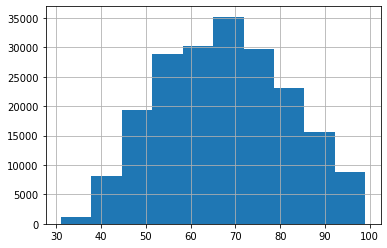

In [21]:
data['text'].str.len().hist()

###Words in each sentence

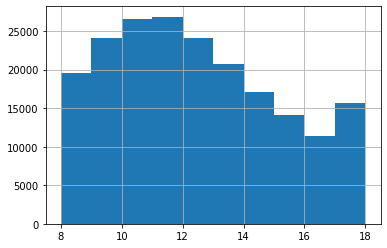

In [22]:
plot_word_number_histogram(data['text']) 

###Labels

In [24]:
Np = np.sum(data['humor'].values == True)
Nn = np.sum(data['humor'].values == False)
print(f'Number of positive samples={Np}')
print(f'Number of negative samples={Nn}')

Number of positive samples=100000
Number of negative samples=100000


#Dataset pre-processing

We replace uppercase words with their corresponding lowercase and eliminate the special characters. 

In [26]:
import re
#text normalization
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

We need to prepare the dataset to be processed by BERT tokenizer.

In [27]:
all_sentences = data['text'].values
all_words = []
max = 0
for sent in all_sentences:
    temp = []
    temp.append('[CLS]')
    i = 0
    for w in tokenizer.tokenize(sent):
        i+=1
        temp.append(w)
    temp.append('[SEP]')
    all_words.append(temp)
    if i> max:
        max = i
max

47

Now we know the maximum sequence lengt.  We will use this number to limit the lenght of sentences to will be classified.

In [28]:
max_seq_length = max + 2  # Your choice here.

Let's review an example:

In [29]:
s = data['text'][200]
stokens = tokenizer.tokenize(s)
stokens = ["[CLS]"] + stokens + ["[SEP]"]

input_ids = get_ids(stokens, tokenizer, max_seq_length)
input_masks = get_masks(stokens, max_seq_length)
input_segments = get_segments(stokens, max_seq_length)

In [30]:
print(stokens)
print(input_ids)
print(input_masks)
print(input_segments)

['[CLS]', 'the', 'hardest', 'part', 'about', 'online', 'dating', 'finding', 'someone', 'who', 'clicks', 'with', 'you', '[SEP]']
[101, 1996, 18263, 2112, 2055, 3784, 5306, 4531, 2619, 2040, 29225, 2007, 2017, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
print(len(stokens))
print(len(input_ids))
print(len(input_masks))
print(len(input_segments))

14
49
49
49


#Model


##Defining the model

In [32]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

In [33]:
pool_embs, all_embs = model.predict([np.array(input_ids).reshape(1,-1),np.array(input_masks).reshape(1,-1),np.array(input_segments).reshape(1,-1)])

In [34]:
pool_embs.shape

(1, 768)

In [35]:
all_embs.shape

(1, 49, 768)

In [36]:
input_ids = np.zeros((len(all_words),max_seq_length))
input_masks = np.zeros((len(all_words),max_seq_length))
input_segments = np.zeros((len(all_words),max_seq_length))
for i in range(len(all_words)):
    input_ids[i,:] = np.array(get_ids(all_words[i], tokenizer, max_seq_length)).reshape(1,-1)
    input_masks[i,:] = np.array(get_masks(all_words[i], max_seq_length)).reshape(1,-1)
    input_segments[i,:] = np.array(get_segments(all_words[i], max_seq_length)).reshape(1,-1)

In [37]:
from sklearn.preprocessing import LabelEncoder
y = data['humor'].values
Encoder = LabelEncoder()
Y = Encoder.fit_transform(y)

In [38]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout

In [39]:
from sklearn.model_selection import train_test_split
input_ids_tr, input_ids_te, input_masks_tr, input_masks_te, input_segments_tr, input_segments_te, y_tr, y_te = train_test_split(input_ids, input_masks, input_segments, Y, test_size=0.2, random_state=2022)

In [40]:
input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])


##Fine tuning

In [41]:
recurrent = LSTM(4,activation='tanh')(sequence_output)
        
dense1 = Dense(10,activation='relu')(recurrent)
drop1 = Dropout(0.1)(dense1)
        
dense2 = Dense(1,activation='sigmoid')(drop1)

##Creating the model

In [42]:
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[dense2])

##Model summary

In [43]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 49)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 49)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 49)]         0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 49, 768)]                 'input_mask[0][0]',       

##Model training

In [44]:
batch_size=32
epochs=5
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
history=model.fit([input_ids_tr,input_masks_tr,input_segments_tr], y_tr, validation_split=0.1,batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/5
4500/4500 [==============================] - 410s 88ms/step - loss: 0.1870 - accuracy: 0.9289 - val_loss: 0.1535 - val_accuracy: 0.9424
Epoch 2/5
4500/4500 [==============================] - 388s 86ms/step - loss: 0.1340 - accuracy: 0.9496 - val_loss: 0.1362 - val_accuracy: 0.9457
Epoch 3/5
4500/4500 [==============================] - 388s 86ms/step - loss: 0.1198 - accuracy: 0.9552 - val_loss: 0.1357 - val_accuracy: 0.9463
Epoch 4/5
4500/4500 [==============================] - 388s 86ms/step - loss: 0.1113 - accuracy: 0.9585 - val_loss: 0.1246 - val_accuracy: 0.9506
Epoch 5/5
4500/4500 [==============================] - 393s 87ms/step - loss: 0.1052 - accuracy: 0.9608 - val_loss: 0.1244 - val_accuracy: 0.9524


##Model evaluation

In [46]:
y_pred = np.round(model.predict([input_ids_te,input_masks_te,input_segments_te]))

#Results

In [47]:
print('Accuracy = {}'.format(accuracy_score(y_te,y_pred)))
print('Recall = {}'.format(recall_score(y_te,y_pred)))

Accuracy = 0.956725
Recall = 0.9548364509352806


#Analysis

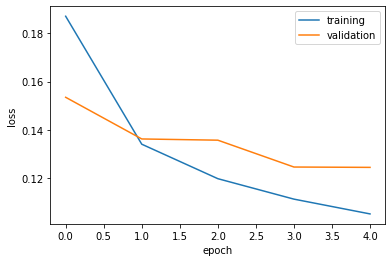

In [51]:
plt.plot(np.arange(epochs), history.history['loss'], label='training')
plt.plot(np.arange(epochs), history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();

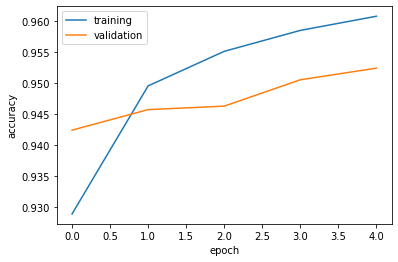

In [49]:
plt.plot(np.arange(epochs), history.history['accuracy'], label='training')
plt.plot(np.arange(epochs), history.history['val_accuracy'], label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

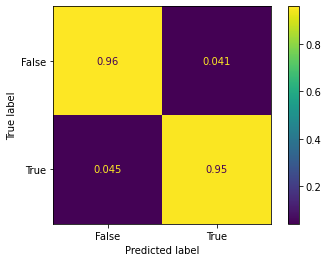

In [57]:
cm = confusion_matrix(y_te, y_pred, labels=class_names,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot()
plt.show()

#References

[Ramos, R., Arias, J., Fundamentos de Deep Learning, Universidad de Antioquia](https://rramosp.github.io/2021.deeplearning/content/U5.08%20-%20Self-Attention%20-%20Transformer%20-%20BERT.html)

[Ramos, R., Arias, J., LAB 5.3, Fundamentos de Deep Learning, Universidad de Antioquia](https://rramosp.github.io/2021.deeplearning/content/U5%20LAB%2003%20-%20Sentiment%20Analysis%20using%20BERT.html)

[Deep learning model training history in keras, www.machinelearningmastery. Accessed on 26/06/2022](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)



